In [1]:
!pip install gymnasium

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.9/953.9 kB 10.2 MB/s eta 0:00:00


In [2]:
import gymnasium as gym
import random
import numpy as np
from collections import defaultdict
import matplotlib.pyplot as plt
from tqdm import tqdm

In [3]:
class TrafficSignalEnv(gym.Env):
    def __init__(self, mode="normal"):
        super(TrafficSignalEnv, self).__init__()
        self.mode = mode
        # Assuming a discrete action space with 4 actions: North, South, East, West
        # or NS-TR, NS-L, EW-TR, EW-L
        self.action_space = gym.spaces.Discrete(4)
        # State space can be represented in various ways, this is a simple example
        self.observation_space = gym.spaces.Dict(
            {
                "North": gym.spaces.Dict(
                    {
                        "vehicles_through_right": gym.spaces.Discrete(8),
                        "vehicles_left": gym.spaces.Discrete(11),
                        "cycles_waited_through_right": gym.spaces.Discrete(6),
                        "cycles_waited_left": gym.spaces.Discrete(6),
                        "pedestrians_parallel": gym.spaces.Discrete(11),
                        "cycles_pedestrians_wait": gym.spaces.Discrete(6),
                        "emergency_vehicles_through_right": gym.spaces.Discrete(1),
                        "emergency_vehicles_left": gym.spaces.Discrete(1),
                    }
                ),
                "South": gym.spaces.Dict(
                    {
                        "vehicles_through_right": gym.spaces.Discrete(8),
                        "vehicles_left": gym.spaces.Discrete(11),
                        "cycles_waited_through_right": gym.spaces.Discrete(6),
                        "cycles_waited_left": gym.spaces.Discrete(6),
                        "pedestrians_parallel": gym.spaces.Discrete(11),
                        "cycles_pedestrians_wait": gym.spaces.Discrete(6),
                        "emergency_vehicles_through_right": gym.spaces.Discrete(1),
                        "emergency_vehicles_left": gym.spaces.Discrete(1),
                    }
                ),
                "East": gym.spaces.Dict(
                    {
                        "vehicles_through_right": gym.spaces.Discrete(8),
                        "vehicles_left": gym.spaces.Discrete(11),
                        "cycles_waited_through_right": gym.spaces.Discrete(6),
                        "cycles_waited_left": gym.spaces.Discrete(6),
                        "pedestrians_parallel": gym.spaces.Discrete(11),
                        "cycles_pedestrians_wait": gym.spaces.Discrete(6),
                        "emergency_vehicles_through_right": gym.spaces.Discrete(1),
                        "emergency_vehicles_left": gym.spaces.Discrete(1),
                    }
                ),
                "West": gym.spaces.Dict(
                    {
                        "vehicles_through_right": gym.spaces.Discrete(8),
                        "vehicles_left": gym.spaces.Discrete(11),
                        "cycles_waited_through_right": gym.spaces.Discrete(6),
                        "cycles_waited_left": gym.spaces.Discrete(6),
                        "pedestrians_parallel": gym.spaces.Discrete(11),
                        "cycles_pedestrians_wait": gym.spaces.Discrete(6),
                        "emergency_vehicles_through_right": gym.spaces.Discrete(1),
                        "emergency_vehicles_left": gym.spaces.Discrete(1),
                    }
                ),
            }
        )

    def reset(self, seed=None, options=None):
        super().reset(seed=seed, options=options)
        self.state = self._generate_traffic_scenario()
        return self.state, {}

    def step(self, action):
        correct_decision = self._decide_signal(action)
        reward = 1 if action == correct_decision else 0
        done = True
        return self.state, reward, done, done, {}

    def render(self, mode="human"):
        # Rendering logic (optional)
        pass

    def _generate_random_traffic_conditions(self):
        return {
            "vehicles_through_right": random.randint(0, 7),
            "vehicles_left": random.randint(0, 10),
            "cycles_waited_through_right": random.randint(0, 5),
            "cycles_waited_left": random.randint(0, 5),
            "pedestrians_parallel": random.randint(0, 10),
            "cycles_pedestrians_wait": random.randint(0, 5),
            "emergency_vehicles_through_right": 0,
            "emergency_vehicles_left": 0,
        }

    def _generate_traffic_scenario(self):
        directions = ["North", "South", "East", "West"]
        scenario = {
            direction: self._generate_random_traffic_conditions()
            for direction in directions
        }
        return scenario

    def _decide_signal(self, action):
        if self.mode == "normal":
            combined_lane_pairs = self._combine_lane_pairs(self.state)
            decision = self._decide_signal_normal(self.state, combined_lane_pairs)
            # print(f"Decision: {decision}")
            action_map = {"NS-TR": 0, "NS-L": 1, "EW-TR": 2, "EW-L": 3}
            return action_map.get(decision)
        elif self.mode == "round_robin":
            decision = self._decide_signal_round_robin(self.state)
            # print(f"Decision: {decision}")
            action_map = {"North": 0, "South": 1, "East": 2, "West": 3}
            return action_map.get(decision)
        else:
            raise ValueError("Invalid mode")

    def _decide_signal_normal(self, directions_data, combined_lane_pairs):
        # Check for emergency vehicles
        # for direction, conditions in directions_data.items():
        #     if (
        #         conditions["emergency_vehicles_through_right"] > 0
        #         or conditions["emergency_vehicles_left"] > 0
        #     ):
        #         return f"Emergency: Open {direction}"

        # Decide based on traffic coefficients
        max_coefficient = -1
        signal_to_open = None
        for lane_pair, vehicles in combined_lane_pairs.items():
            traffic_coefficient = self._calculate_traffic_coefficient(
                vehicles, 1, 0, 0
            )  # Simplified for this example
            if traffic_coefficient > max_coefficient:
                max_coefficient = traffic_coefficient
                signal_to_open = lane_pair

        return signal_to_open

    def _decide_signal_round_robin(self, directions_data):
        max_coef = -1
        signal_to_open = None
        traffic_coefficients = {}
        for direction, data in directions_data.items():
            coef = (
                data["vehicles_through_right"] * data["cycles_waited_through_right"]
                + data["vehicles_left"] * data["cycles_waited_left"]
                + data["pedestrians_parallel"] * data["cycles_pedestrians_wait"]
            )
            traffic_coefficients[direction] = coef

        for direction, coef in traffic_coefficients.items():
            if (
                directions_data[direction]["emergency_vehicles_through_right"] > 0
                or directions_data[direction]["emergency_vehicles_left"] > 0
            ):
                signal_to_open = f"Emergency: Open {direction}"
                break
            if coef > max_coef:
                max_coef = coef
                signal_to_open = direction

        return signal_to_open

    def _combine_lane_pairs(self, directions_data):
        # Combine North-South and East-West lane pairs
        ns_through_right = (
            directions_data["North"]["vehicles_through_right"]
            + directions_data["South"]["vehicles_through_right"]
        )
        ns_left = (
            directions_data["North"]["vehicles_left"]
            + directions_data["South"]["vehicles_left"]
        )
        ew_through_right = (
            directions_data["East"]["vehicles_through_right"]
            + directions_data["West"]["vehicles_through_right"]
        )
        ew_left = (
            directions_data["East"]["vehicles_left"]
            + directions_data["West"]["vehicles_left"]
        )

        combined = {
            "NS-TR": ns_through_right,
            "NS-L": ns_left,
            "EW-TR": ew_through_right,
            "EW-L": ew_left,
        }
        return combined

    def _calculate_traffic_coefficient(
        self, vehicles, cycles_waited, pedestrians, cycles_pedestrians_wait
    ):
        return vehicles * (cycles_waited + 1) + (pedestrians / 4) * (
            cycles_pedestrians_wait + 1
        )


if __name__ == "__main__":
    # Testing the environment in 'normal' mode
    print("Testing in 'normal' mode:")
    env = TrafficSignalEnv(mode="normal")
    for _ in range(5):  # Run 5 test cases
        state = env.reset()
        action = env.action_space.sample()  # Random action
        next_state, reward, done, _, info = env.step(action)
        print(f"State: {state}, Action: {action}, Reward: {reward}, Done: {done}")

    # Testing the environment in 'round_robin' mode
    print("\nTesting in 'round_robin' mode:")
    env = TrafficSignalEnv(mode="round_robin")
    for _ in range(5):  # Run 5 test cases
        state = env.reset()
        action = env.action_space.sample()  # Random action
        next_state, reward, done, _, info = env.step(action)
        print(f"State: {state}, Action: {action}, Reward: {reward}, Done: {done}")


Testing in 'normal' mode:
State: ({'North': {'vehicles_through_right': 4, 'vehicles_left': 6, 'cycles_waited_through_right': 5, 'cycles_waited_left': 0, 'pedestrians_parallel': 3, 'cycles_pedestrians_wait': 1, 'emergency_vehicles_through_right': 0, 'emergency_vehicles_left': 0}, 'South': {'vehicles_through_right': 4, 'vehicles_left': 10, 'cycles_waited_through_right': 0, 'cycles_waited_left': 5, 'pedestrians_parallel': 7, 'cycles_pedestrians_wait': 5, 'emergency_vehicles_through_right': 0, 'emergency_vehicles_left': 0}, 'East': {'vehicles_through_right': 5, 'vehicles_left': 10, 'cycles_waited_through_right': 4, 'cycles_waited_left': 5, 'pedestrians_parallel': 6, 'cycles_pedestrians_wait': 3, 'emergency_vehicles_through_right': 0, 'emergency_vehicles_left': 0}, 'West': {'vehicles_through_right': 1, 'vehicles_left': 8, 'cycles_waited_through_right': 2, 'cycles_waited_left': 4, 'pedestrians_parallel': 10, 'cycles_pedestrians_wait': 0, 'emergency_vehicles_through_right': 0, 'emergency_vehi

In [4]:
class TrafficSignalAgent:
    def __init__(self, action_space, learning_rate, initial_epsilon, epsilon_decay, final_epsilon, discount_factor=0.95):
        self.q_values = defaultdict(lambda: np.zeros(action_space.n))
        self.lr = learning_rate
        self.discount_factor = discount_factor
        self.epsilon = initial_epsilon
        self.epsilon_decay = epsilon_decay
        self.final_epsilon = final_epsilon
        self.training_error = []

    def get_action(self, state):
        if np.random.random() < self.epsilon:
            return np.array([np.random.randint(4)])  # Random action for exploration
        else:
            state_key = tuple([tuple(direction.values()) for direction in obs.values()])
            return np.argmax(self.q_values[state_key])

    def update(self, obs, action, reward, done, next_obs):
        state_key = tuple([tuple(direction.values()) for direction in obs.values()])
        next_state_key = tuple([tuple(direction.values()) for direction in next_obs.values()])

        future_q_value = (not done) * np.max(self.q_values[next_state_key])
        temporal_difference = reward + self.discount_factor * future_q_value - self.q_values[state_key][action]

        self.q_values[state_key][action] += self.lr * temporal_difference
        self.training_error.append(temporal_difference)

        # if self.epsilon > self.final_epsilon:
        #     self.epsilon *= self.epsilon_decay
    def decay_epsilon(self):
        self.epsilon = max(self.final_epsilon, self.epsilon - self.epsilon_decay)

In [5]:
# hyperparameters
learning_rate = 0.01
n_episodes = 100_000
start_epsilon = 1.0
epsilon_decay = start_epsilon / (n_episodes / 2)  # reduce the exploration over time
final_epsilon = 0.1

agent = TrafficSignalAgent(
    action_space = env.action_space,
    learning_rate=learning_rate,
    initial_epsilon=start_epsilon,
    epsilon_decay=epsilon_decay,
    final_epsilon=final_epsilon,
)

In [6]:
env = TrafficSignalEnv(mode="normal")

In [7]:
env = gym.wrappers.RecordEpisodeStatistics(env, deque_size=n_episodes)

for episode in tqdm(range(n_episodes)):
    obs, _ = env.reset()
    done = False

    # play one episode
    while not done:
        action = agent.get_action(obs)
        next_obs, reward, done, _, info = env.step(action)
        # update the agent
        agent.update(obs, action, reward, done, next_obs)

        obs = next_obs

    agent.decay_epsilon()

100%|██████████| 100000/100000 [00:19<00:00, 5181.93it/s]


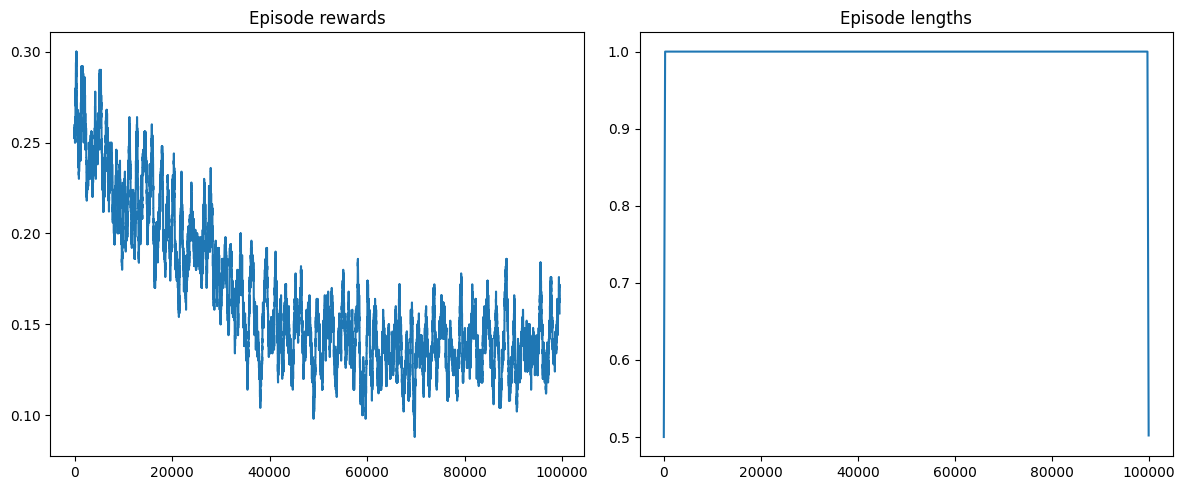

In [8]:
rolling_length = 500
fig, axs = plt.subplots(ncols=2, figsize=(12, 5))
axs[0].set_title("Episode rewards")
# compute and assign a rolling average of the data to provide a smoother graph
reward_moving_average = (
    np.convolve(
        np.array(env.return_queue).flatten(), np.ones(rolling_length), mode="valid"
    )
    / rolling_length
)
axs[0].plot(range(len(reward_moving_average)), reward_moving_average)
axs[1].set_title("Episode lengths")
length_moving_average = (
    np.convolve(
        np.array(env.length_queue).flatten(), np.ones(rolling_length), mode="same"
    )
    / rolling_length
)
axs[1].plot(range(len(length_moving_average)), length_moving_average)
plt.tight_layout()
plt.show()

In [12]:
env = TrafficSignalEnv(mode="round_robin")

In [13]:
# hyperparameters
learning_rate = 0.01
n_episodes = 100_000
start_epsilon = 1.0
epsilon_decay = start_epsilon / (n_episodes / 2)  # reduce the exploration over time
final_epsilon = 0.1

agent = TrafficSignalAgent(
    action_space = env.action_space,
    learning_rate=learning_rate,
    initial_epsilon=start_epsilon,
    epsilon_decay=epsilon_decay,
    final_epsilon=final_epsilon,
)

In [14]:
env = gym.wrappers.RecordEpisodeStatistics(env, deque_size=n_episodes)

for episode in tqdm(range(n_episodes)):
    obs, _ = env.reset()
    done = False

    # play one episode
    while not done:
        action = agent.get_action(obs)
        next_obs, reward, done, _, info = env.step(action)
        # update the agent
        agent.update(obs, action, reward, done, next_obs)

        obs = next_obs

    agent.decay_epsilon()

100%|██████████| 100000/100000 [00:13<00:00, 7300.71it/s]


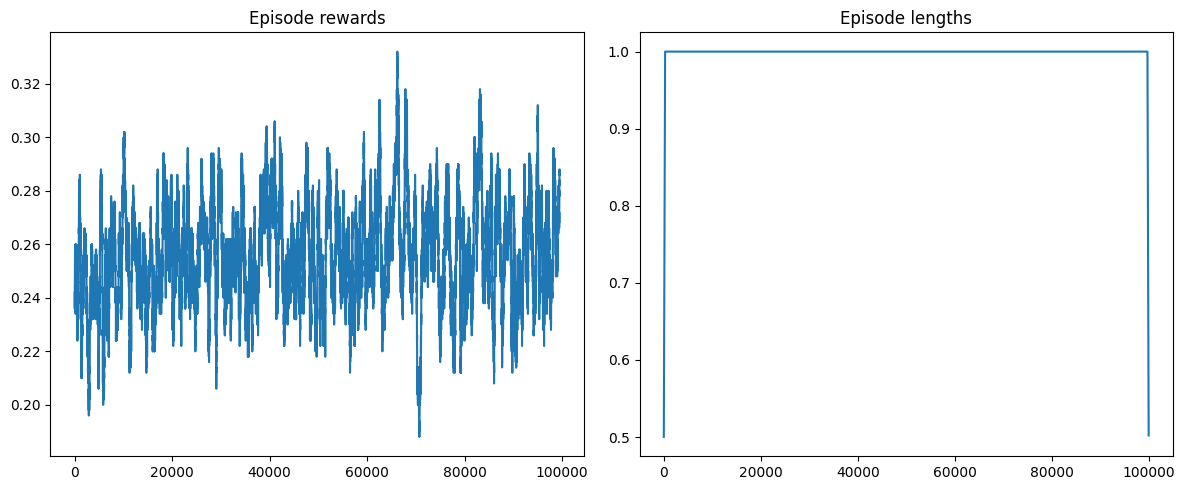

In [15]:
rolling_length = 500
fig, axs = plt.subplots(ncols=2, figsize=(12, 5))
axs[0].set_title("Episode rewards")
# compute and assign a rolling average of the data to provide a smoother graph
reward_moving_average = (
    np.convolve(
        np.array(env.return_queue).flatten(), np.ones(rolling_length), mode="valid"
    )
    / rolling_length
)
axs[0].plot(range(len(reward_moving_average)), reward_moving_average)
axs[1].set_title("Episode lengths")
length_moving_average = (
    np.convolve(
        np.array(env.length_queue).flatten(), np.ones(rolling_length), mode="same"
    )
    / rolling_length
)
axs[1].plot(range(len(length_moving_average)), length_moving_average)
plt.tight_layout()
plt.show()